## Graph model selection outputs

In [23]:
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt

run = "base_strongaug_ema_inf_sq" #"base_strongaug_ema_inf_sq"
outputs_filename = f"/home/heather/GitHub/aldi0107/outputs/urchininf/{run}/model_selection/model_selection.json"
df = pd.read_json(outputs_filename)  # or however you load your DataFrame
# Create relplot
df['model_shortname'] = df['model'].apply(lambda x: x[-17:-4])
df['domain'] = df['source'].apply(lambda x: "source" if x else "target")
df['dataset_og'] = df['dataset'].apply(lambda x: x[4:-14])

df = df[df['model_shortname'] != "I/model_final"]


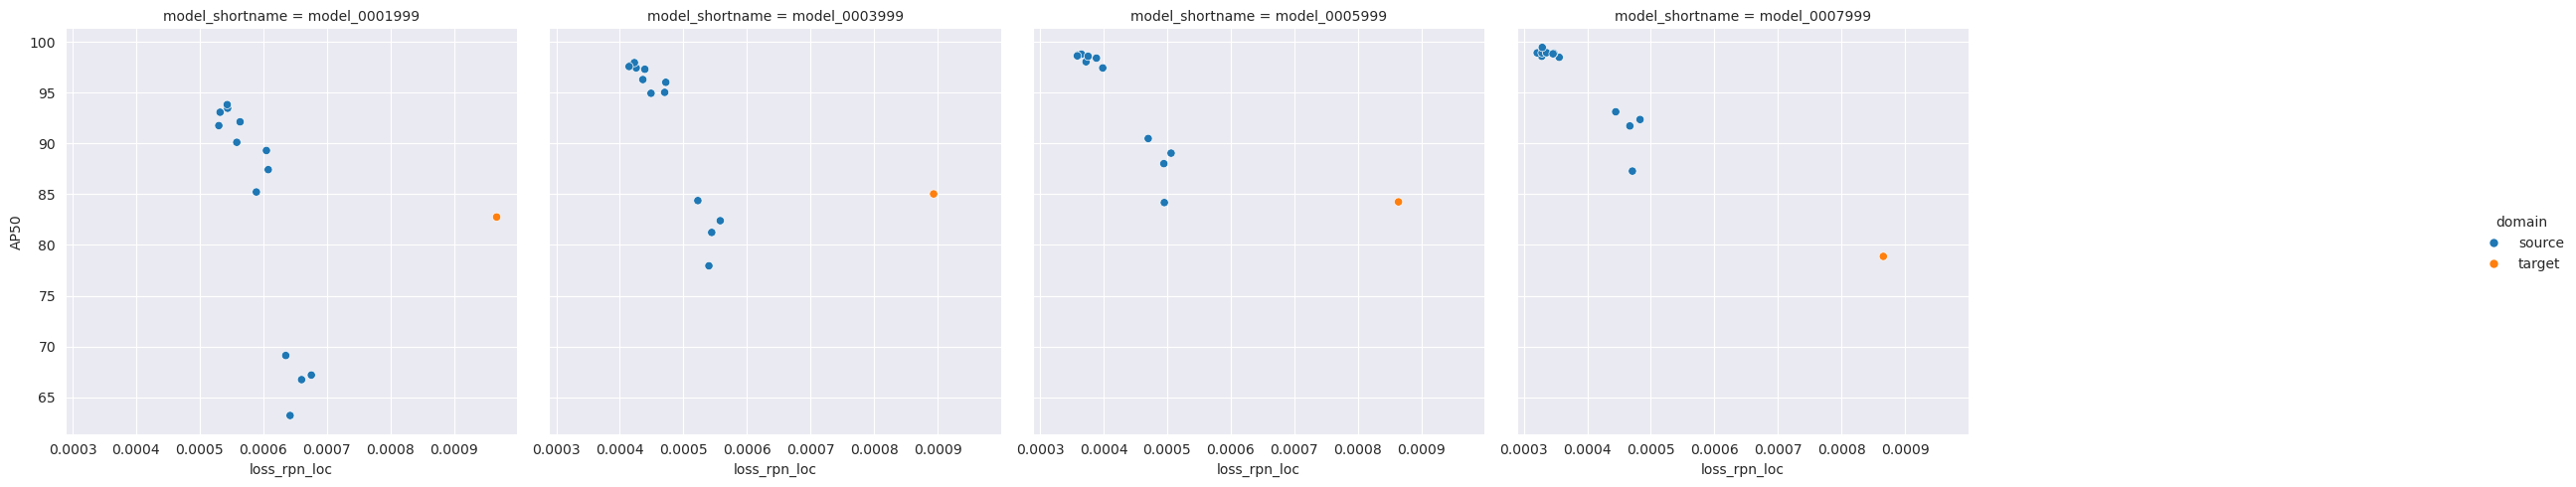

In [24]:


    
sns.relplot(data=df, x='loss_rpn_loc', y='AP50', hue='domain', col='model_shortname', kind='scatter', col_wrap=5)



# Show plot
plt.show()

In [25]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

factor = 'loss_box_reg'
eval = 'AP50'
eval_calc = f"{eval}_calc"
df[eval_calc] = eval
model_names = sorted(list(set(df['model_shortname'])))
for m in model_names:
    model = LinearRegression()
    model_src_data = df.loc[(df['model_shortname']==m) & (df['domain']=='source')]
    if len(model_src_data) > 0:
        model_tgt_data = df.loc[(df['model_shortname']==m) & (df['domain'] == 'target')]
        model.fit(model_src_data[[factor]], model_src_data[eval])
        print(model)
        out = model.predict(model_tgt_data[[factor]])
        df.loc[(df['model_shortname']==m) & (df['domain'] == 'target'), eval_calc] = out
        model_tgt_data = df.loc[(df['model_shortname']==m) & (df['domain'] == 'target')]
        print(m, np.mean(model_tgt_data[eval]), np.mean(model_tgt_data[eval_calc]))

LinearRegression()
model_0001999 82.7462333473 -1.5230354082202666
LinearRegression()
model_0003999 85.0193880545 32.240389739573374
LinearRegression()
model_0005999 84.2361495937 55.28019350384109
LinearRegression()
model_0007999 78.8703613613 66.63876201469971


In [26]:
#sns.lmplot(data=df, x=factor, y=eval_calc, hue='domain', col='model_shortname')
results_df = df[['domain', eval, factor, 'model_shortname']].copy()
results_df['GT'] = 'Yes'

predict_df = df.loc[df['domain']=='target',['domain', eval_calc, factor, 'model_shortname']].copy()
predict_df['GT'] = 'No'
predict_df.columns = results_df.columns


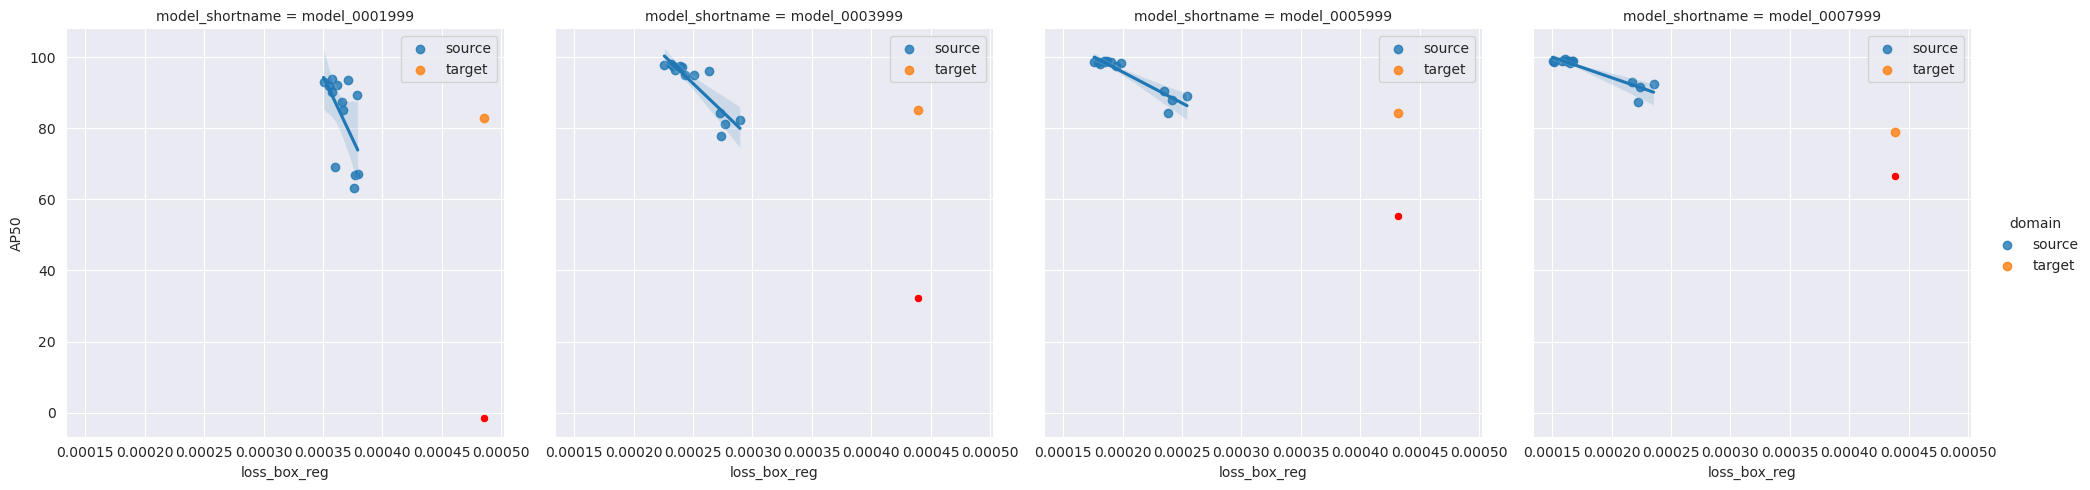

In [27]:
summary_df = pd.concat([results_df, predict_df], ignore_index=True)
# Create a FacetGrid
g = sns.lmplot(data=results_df, x=factor, y=eval, hue='domain', col='model_shortname', col_wrap=4)

# Add scatter plot and linear regression line to each facet
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the region
    mod_name = ax.get_title().split(' = ')[1]
    
    # select the data for the region
    data = predict_df[predict_df.model_shortname.eq(mod_name)]
    data = data[(data['domain']=='target') & (data['GT'] == 'No')]
    sns.scatterplot(data=data, x=factor, y=eval, ax=ax, color='red')
